In [1]:
# Clone the repository
!git clone https://github.com/tahmid0007/VisualTransformers.git
%cd VisualTransformers

# Install dependencies
!pip install torch torchvision einops matplotlib


Cloning into 'VisualTransformers'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 29 (delta 7), reused 3 (delta 3), pack-reused 20 (from 1)
Receiving objects: 100% (29/29), 75.96 KiB | 37.98 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/VisualTransformers


In [4]:
# Step 1: Install dependencies
!pip install torch torchvision einops matplotlib

# Step 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from einops import rearrange


In [11]:
class VisualTransformer(nn.Module):
    def __init__(self, *, image_size=32, patch_size=8, num_classes=10, dim=64, depth=4, heads=4, mlp_dim=128, dropout=0.1):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2

        # Linear projection of flattened patches to dim
        self.patch_to_embedding = nn.Linear(patch_size * patch_size * 3, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                nn.LayerNorm(dim),
                nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout),
                nn.LayerNorm(dim),
                nn.Sequential(
                    nn.Linear(dim, mlp_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(mlp_dim, dim),
                    nn.Dropout(dropout)
                )
            ]))

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # img shape: (batch, channels, height, width)
        # Convert image patches to tokens
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_to_embedding(x)
        x += self.pos_embedding
        x = self.dropout(x)

        for norm1, attn, norm2, mlp in self.layers:
            x_norm = norm1(x)
            # MultiheadAttention expects (seq_len, batch, embed_dim)
            x_norm = x_norm.transpose(0, 1)
            attn_out, attn_weights = attn(x_norm, x_norm, x_norm)
            attn_out = attn_out.transpose(0, 1)
            x = x + attn_out
            x = x + mlp(norm2(x))

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x), attn_weights


In [12]:
# Step 4: Load CIFAR-10 Dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
transform_test = transform_train

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Step 5: Train Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VisualTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
transform_test = transform_train

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [14]:
# Step 5: Train Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VisualTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Step 6: Simple Training Loop for 3 Epochs
for epoch in range(3):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1} train loss: {running_loss/len(trainloader):.3f} | accuracy: {100*correct/total:.2f}%")

Epoch 1 train loss: 1.738 | accuracy: 37.15%
Epoch 2 train loss: 1.504 | accuracy: 45.68%
Epoch 3 train loss: 1.409 | accuracy: 49.25%


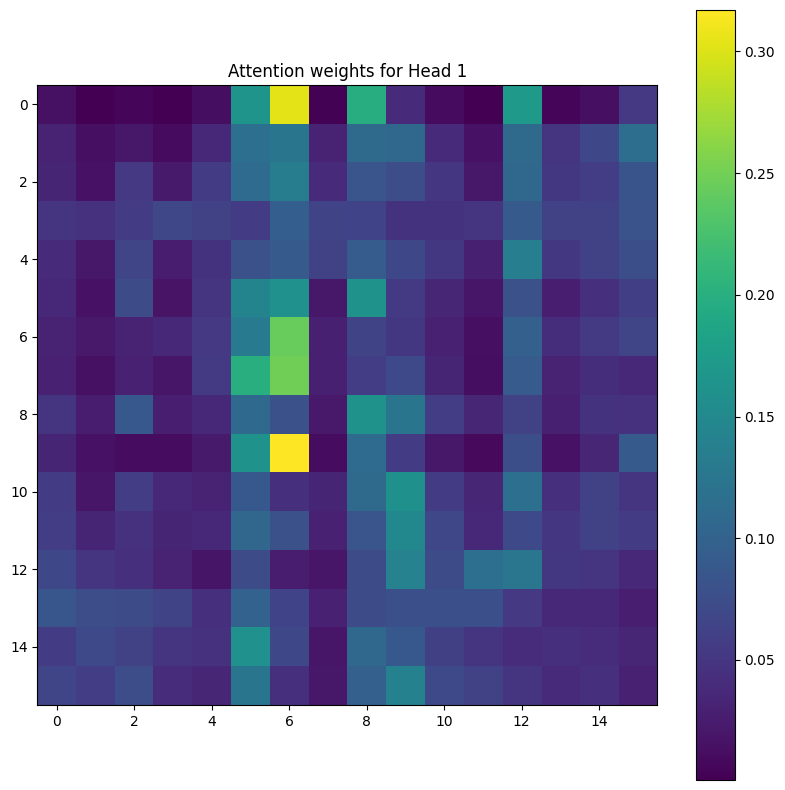

In [17]:
# Step 7: Visualize Attention on a Sample Image
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    output, attn_weights = model(images[:1])

# attn_weights shape: (num_heads, seq_len, seq_len)
attn = attn_weights[0].cpu()

plt.figure(figsize=(10,10))
plt.imshow(attn, cmap='viridis')
plt.colorbar()
plt.title("Attention weights for Head 1")
plt.show()